In [1]:
import os
import time
import copy
import shutil  # Used in preparing the dataset.
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

import pretrainedmodels.utils as utils

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/dataset.zip

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [5]:
!pip install pretrainedmodels

In [6]:
import pretrainedmodels

In [7]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [40]:
# Import xception pre-trained model
model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model_conv = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model_conv.eval()
tf_img = utils.TransformImage(model_conv)

In [41]:
data_transforms = tf_img

In [42]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]
transform_types = ["train", "val"]  # Do not transform the test set (since it is not learned)

batch_size = 16
shuffle = True
num_workers = 1

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in transform_types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms)  # Do not transform test set, only load it. 

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [43]:
class_names

['merger', 'noninteracting']

In [44]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

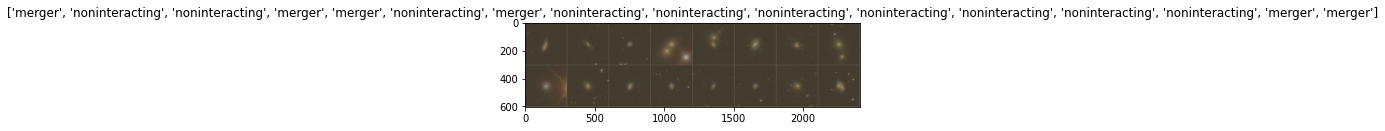

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [46]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [48]:
# Hyperparameters from the paper (A1. Main Experiment)
n_epochs = 40
lr = 0.000015
momentum = 0.9

In [49]:
model_conv

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [50]:
# model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.last_linear.in_features
model_conv.last_linear = nn.Linear(num_ftrs, 2)
# model_conv.last_linear = nn.Linear(int(num_ftrs/4), 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.last_linear.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [51]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=n_epochs)

Epoch 0/39
----------
train Loss: 0.6687 Acc: 0.6071
val Loss: 0.6580 Acc: 0.6259

Epoch 1/39
----------
train Loss: 0.6547 Acc: 0.6255
val Loss: 0.6520 Acc: 0.6259

Epoch 2/39
----------
train Loss: 0.6494 Acc: 0.6250
val Loss: 0.6469 Acc: 0.6257

Epoch 3/39
----------
train Loss: 0.6443 Acc: 0.6253
val Loss: 0.6421 Acc: 0.6264

Epoch 4/39
----------
train Loss: 0.6401 Acc: 0.6259
val Loss: 0.6381 Acc: 0.6262

Epoch 5/39
----------
train Loss: 0.6356 Acc: 0.6268
val Loss: 0.6317 Acc: 0.6274

Epoch 6/39
----------
train Loss: 0.6324 Acc: 0.6295
val Loss: 0.6286 Acc: 0.6327

Epoch 7/39
----------
train Loss: 0.6280 Acc: 0.6324
val Loss: 0.6250 Acc: 0.6404

Epoch 8/39
----------
train Loss: 0.6246 Acc: 0.6356
val Loss: 0.6194 Acc: 0.6447

Epoch 9/39
----------
train Loss: 0.6208 Acc: 0.6419
val Loss: 0.6188 Acc: 0.6467

Epoch 10/39
----------
train Loss: 0.6189 Acc: 0.6464
val Loss: 0.6149 Acc: 0.6617

Epoch 11/39
----------
train Loss: 0.6139 Acc: 0.6521
val Loss: 0.6118 Acc: 0.6634

Ep

In [52]:
torch.save(model_conv.state_dict(), "xception_40epochs.pth")

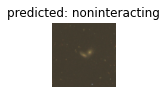

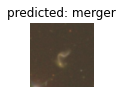

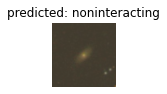

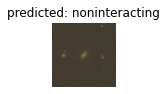

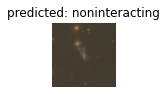

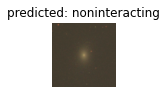

In [53]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [76]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model_conv.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model_conv(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 74.13706853426713


In [77]:
print(f"Accuracy: {correct/total}")

Accuracy: 0.7413706853426714


In [78]:
for pred in all_preds:
  pred = pred.cpu().numpy()

In [79]:
preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
targets_ = np.hstack([target_.cpu().numpy() for target_ in all_targets])

In [80]:
!pip install plot-metric

In [81]:
from plot_metric.functions import BinaryClassification

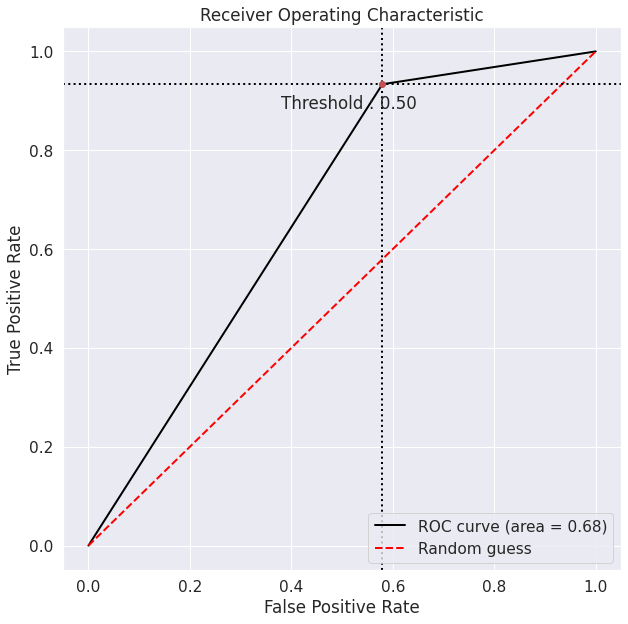

In [82]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [83]:
from sklearn.metrics import confusion_matrix

In [84]:
conf_matrix = confusion_matrix(targets_, preds)
print(conf_matrix)

[[ 630  868]
 [ 166 2334]]


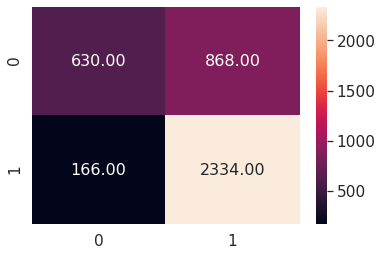

In [85]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".2f") # font size

plt.show()

In [87]:
outs_last_excluded = np.hstack([out.cpu().numpy() for out in outs[:-1]])

In [88]:
final_outs = np.hstack([ans for ans in outs_last_excluded])

In [90]:
outs = [out.cpu().numpy() for out in outs]

In [91]:
answer = [np.hstack(outs[i][:, 0]) for i in range(len(outs))]

In [92]:
class_1_raw_preds = np.hstack([ans for ans in answer])

In [93]:
answer2 = [np.hstack(outs[i][:, -1]) for i in range(len(outs))]

In [94]:
class_2_raw_preds = np.hstack([ans for ans in answer2])

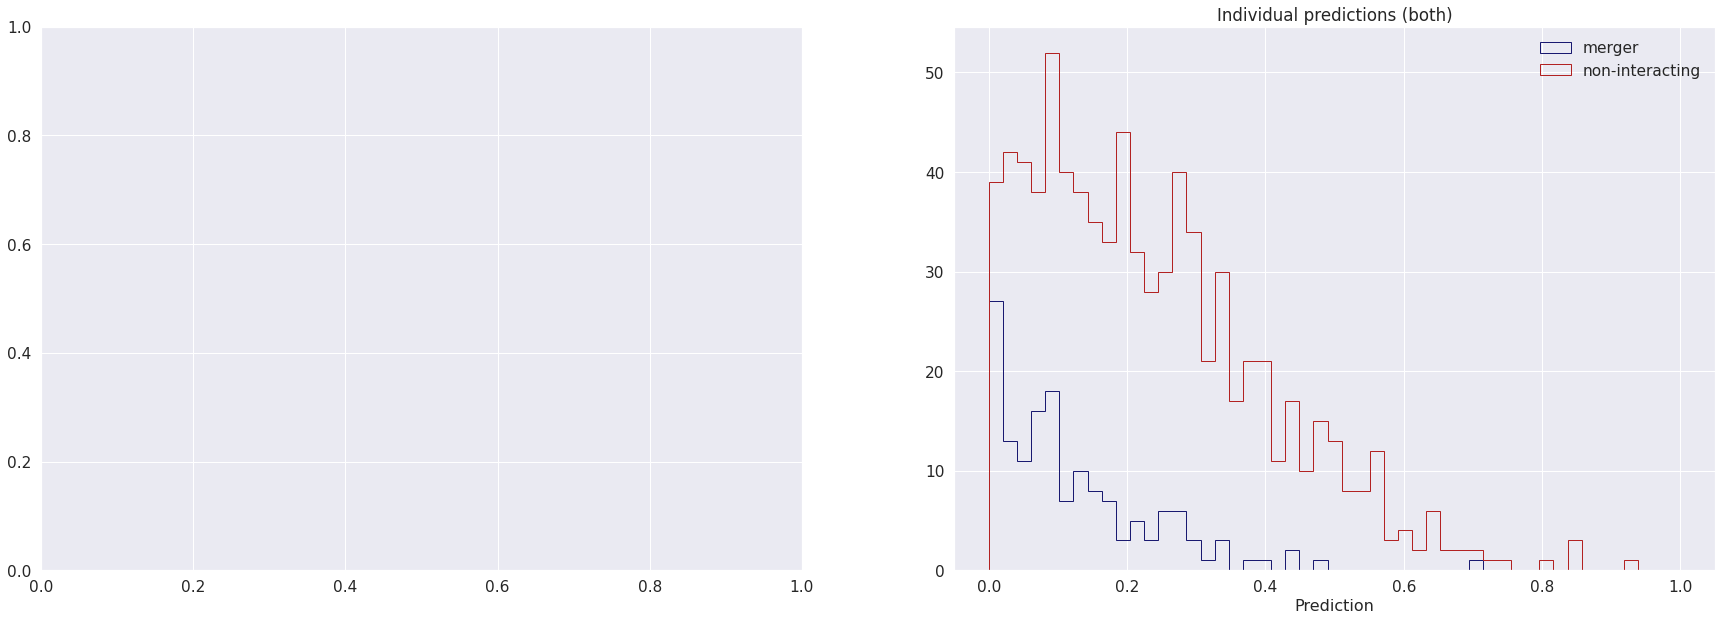

In [95]:
import matplotlib.pyplot as plt

fig, (_, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All")
hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# ax1.set_xlabel("Prediction", fontsize=16);
# ax1.set_ylabel("", fontsize=16);
# ax1.set_title("Individual predictions (both)");
# ax1.legend(frameon=False);

ax2.hist(class_1_raw_preds[targets_.astype(bool)], bins=np.linspace(0, 1, 50),
        **hist_style_class1);
ax2.hist(class_2_raw_preds[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
        **hist_style_class2);

ax2.set_xlabel("Prediction", fontsize=16);
ax2.set_ylabel("", fontsize=16);
ax2.set_title("Individual predictions (both)")
ax2.legend(frameon=False);

In [ ]:
!ls dataset_zurich/test/merger | wc -l

1498


In [ ]:
!ls dataset_zurich/test/noninteracting | wc -l

2500


In [ ]:
!ls dataset_zurich/train/merger | wc -l

3003


In [ ]:
!ls dataset_zurich/train/noninteracting | wc -l

5000


In [ ]:
!ls dataset_zurich/val/merger | wc -l

1499


In [ ]:
!ls dataset_zurich/val/noninteracting | wc -l

2500
